In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

import openpyxl

In [2]:
from pybamm import exp, constants, Parameter
def nmc_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust(c_e, c_s_surf, T):
    i_ref = 5.028  # (A/m2)
    alpha = 0.43
    E_r = 2.401e4
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))
    c_p_max = Parameter("Maximum concentration in positive electrode [mol.m-3]")
    c_e_ref = Parameter("Typical electrolyte concentration [mol.m-3]")
    return (
        i_ref
        * arrhenius
        * (c_e / c_e_ref) ** (1 - alpha)
        * (c_s_surf / c_p_max) ** alpha
        * (1 - c_s_surf / c_p_max) ** (1 - alpha))

def nmc_LGM50_diffusivity_ORegan2021_adjust(sto, T):
    a1 = -0.9231
    a2 = -0.4066
    a3 = -0.993
    b1 = 0.3216
    b2 = 0.4532
    b3 = 0.8098
    c0 = -13.96
    c1 = 0.002534
    c2 = 0.003926
    c3 = 0.09924
    d = 1449

    D_ref = (
        10
        ** (
            c0
            + a1 * exp(-((sto - b1) ** 2) / c1)
            + a2 * exp(-((sto - b2) ** 2) / c2)
            + a3 * exp(-((sto - b3) ** 2) / c3)
        )
        * 10  # correcting factor (see O'Regan et al 2021), mark Ruihe change from 2.7 to 10
    )

    E_D_s = d * constants.R
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

def graphite_LGM50_diffusivity_ORegan2021_adjust(sto, T):
    a0 = 11.17
    a1 = -1.553
    a2 = -6.136
    a3 = -9.725
    a4 = 1.85
    b1 = 0.2031
    b2 = 0.5375
    b3 = 0.9144
    b4 = 0.5953
    c0 = -15.11
    c1 = 0.0006091
    c2 = 0.06438
    c3 = 0.0578
    c4 = 0.001356
    d = 2092

    D_ref = (
        10
        ** (
            a0 * sto
            + c0
            + a1 * exp(-((sto - b1) ** 2) / c1)
            + a2 * exp(-((sto - b2) ** 2) / c2)
            + a3 * exp(-((sto - b3) ** 2) / c3)
            + a4 * exp(-((sto - b4) ** 2) / c4)
        )
        * 20  # correcting factor (see O'Regan et al 2021) mark: Ruihe change from 3.0321 
    )

    E_D_s = d * constants.R
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

def graphite_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust(c_e, c_s_surf, T):
    i_ref = 12.4  # (A/m2) replaced with value from Schmalstieg et al. (2018), from 2.668 
    alpha = 0.792
    E_r = 4e4
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    c_n_max = Parameter("Maximum concentration in negative electrode [mol.m-3]")
    c_e_ref = Parameter("Typical electrolyte concentration [mol.m-3]")

    return (
        i_ref
        * arrhenius
        * (c_e / c_e_ref) ** (1 - alpha)
        * (c_s_surf / c_n_max) ** alpha
        * (1 - c_s_surf / c_n_max) ** (1 - alpha))

def nmc_LGM50_electronic_conductivity_ORegan2021_adjust(T):
    E_r = 3.5e3
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    sigma = 0.8473 * arrhenius

    return sigma


In [9]:
Model_0 = pb.lithium_ion.DFN(     
        options={
            "particle": "Fickian diffusion",          
            "SEI":"interstitial-diffusion limited",   
            "SEI on cracks":"true",  
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",      
            "particle mechanics":"swelling and cracking",  
            "loss of active material":"stress-driven", 
            "lithium plating":"partially reversible"      } ) #


In [11]:
for var, equation in Model_0.initial_conditions.items():
    print(var)

Discharge capacity [A.h]
Negative particle crack length
Positive particle crack length
Negative electrode active material volume fraction
Positive electrode active material volume fraction
Total negative electrode interfacial current density variable
Total positive electrode interfacial current density variable
Negative particle concentration
Positive particle concentration
Negative electrode potential
Positive electrode potential
Porosity times concentration(Negative electrode porosity times concentration, Separator porosity times concentration, Positive electrode porosity times concentration)
Electrolyte potential(Negative electrolyte potential, Separator electrolyte potential, Positive electrolyte potential)
Inner SEI thickness
Outer SEI thickness
Inner SEI on cracks thickness
Outer SEI on cracks thickness
Lithium plating concentration
Dead lithium concentration


In [10]:
keys = list(Model_0.variables.keys())
keys.sort()
for key in keys:
    print(key)

Ambient temperature
Ambient temperature [K]
Average negative particle concentration
Average negative particle concentration [mol.m-3]
Average positive particle concentration
Average positive particle concentration [mol.m-3]
Battery voltage [V]
C-rate
Cell temperature
Cell temperature [K]
Cell thickness change [m]
Change in measured open circuit voltage
Change in measured open circuit voltage [V]
Current [A]
Current collector current density
Current collector current density [A.m-2]
Current density variable
Dead lithium concentration
Dead lithium concentration [mol.m-3]
Dead lithium thickness
Dead lithium thickness [m]
Discharge capacity [A.h]
Electrode current density
Electrode transport efficiency
Electrolyte concentration
Electrolyte concentration [Molar]
Electrolyte concentration [mol.m-3]
Electrolyte current density
Electrolyte current density [A.m-2]
Electrolyte flux
Electrolyte flux [mol.m-2.s-1]
Electrolyte potential
Electrolyte potential [V]
Electrolyte transport efficiency
Exc

In [14]:
ChemistryChen=pb.parameter_sets.OKane2022   
ChemistryChen["electrolyte"] = "lipf6_Valoen2005"
Para_0=pb.ParameterValues(chemistry=ChemistryChen)
format_str = '{:<75} {:>20}' 
print(format_str.format('PARAMETER', 'VALUE')) 
print("-"*97) 
for key, value in Para_0.items(): 
    try: 
            print(format_str.format(key, value)) 
    except TypeError: 
            print(format_str.format(key, value.__str__()))

PARAMETER                                                                                  VALUE
-------------------------------------------------------------------------------------------------
Negative current collector thickness [m]                                                 1.2e-05
Negative electrode thickness [m]                                                        8.52e-05
Separator thickness [m]                                                                  1.2e-05
Positive electrode thickness [m]                                                        7.56e-05
Positive current collector thickness [m]                                                 1.6e-05
Electrode height [m]                                                                       0.065
Electrode width [m]                                                                         1.58
Cell cooling surface area [m2]                                                           0.00531
Cell volume [m3]             

In [3]:
# Task: check whether update solution is really working 
V_max = 4.2;        V_min = 2.5;   Temper_RPT = 25; 

#index 
ModelTimer = pb.Timer()
Total_Cycles = 16; save_at_cycles = 1;  

for i in range(0,1):  # Key scan parameters:
    Ratio_excess_i = 1.04;
    cs_Neg_Init_i = 29866 ; Diff_SEI_i = 1.7e-20; # Ruihe old: 28920   default:29866
    R_SEI_i = 2E5;   Bulk_Sol_Con_i = 4541.0;
    D_Li_inSEI_i = 1e-12;    # default: 1e-20 
    c_Li_inte_ref_i = 15;    # default: 15
    Couple_SEI_LiP_i = 1e-6; # default: 1e-6
    k_LiP_i = 1E-10;         # default: 1e-10
    Temper = 25;

Experiment_0   = pb.Experiment(["Discharge at 1 C for 0.5 h", ]   )  
        
for i in range(0,1):  
    ChemistryChen=pb.parameter_sets.Chen2020_coupled   
    ChemistryChen["electrolyte"] = "lipf6_Valoen2005"
    Para_0=pb.ParameterValues(chemistry=ChemistryChen)
    Para_0.update({"Negative electrode diffusivity [m2.s-1]": 2e-13})
    Para_0.update({"Positive electrode diffusivity [m2.s-1]": 1e-13})
    Para_0.update({"Upper voltage cut-off [V]": 4.21})
    Para_0.update({"Lower voltage cut-off [V]": 2.49})
    Para_0.update({'SEI resistivity [Ohm.m]':R_SEI_i}) ;
    Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI_i});
    Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con_i});
    Para_0.update({'Initial electrolyte excessive amount ratio':Ratio_excess_i})   # 
    Para_0.update({'Inner SEI lithium interstitial diffusivity [m2.s-1]':D_Li_inSEI_i})       
    Para_0.update({'Lithium interstitial reference concentration [mol.m-3]':c_Li_inte_ref_i}) 
    Para_0.update({"SEI-plating coupling constant [s-1]": Couple_SEI_LiP_i})     
    Para_0.update({'Lithium plating kinetic rate constant [m.s-1]':k_LiP_i})      
    Para_0.update({"Negative electrode LAM constant propotional term": 0.001})
    Para_0.update({"Positive electrode LAM constant propotional term": 0.001})
    Para_0.update({"Inner SEI reaction proportion":0})
    Para_0.update({"Initial inner SEI thickness [m]":0})
    Para_0.update({"Initial outer SEI thickness [m]": 5e-9})
    Para_0.update({"Ratio of inner and outer SEI exchange current densities": 0 })            
    Para_0.update({'Current solvent concentration in the reservoir [mol.m-3]':Bulk_Sol_Con_i})     
    Para_0.update({'Current electrolyte concentration in the reservoir [mol.m-3]':1000.0})           
    Para_0.update({'Ratio of Li-ion concentration change in electrolyte consider solvent consumption':  
                    1.0 })
    Model_0 = pb.lithium_ion.DFN(     
        options={
            "particle": "Fickian diffusion",          
            "SEI":"sei on cracks",          
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",      
            "particle cracking":"negative",  
            "loss of active material":"both", 
            "lithium plating":"partially reversible"      } ) #
    ModelTimer = pb.Timer()
    mesh_neg = 50; mesh_pos = 50; 
    var = pb.standard_spatial_vars  
    var_pts = {var.x_n: 20,  var.x_s: 10,  var.x_p: 20,  var.r_n: mesh_neg,  var.r_p: mesh_pos,  }
    Sim_0    = pb.Simulation(
        Model_0,        experiment = Experiment_0,
        parameter_values = Para_0,
        solver = pb.CasadiSolver(),
        #var_pts=var_pts,
        ) #mode="safe"
    Sol_0    = Sim_0.solve()
# Update solution:
Experiment_1   = pb.Experiment(["Discharge at 1 C for 0.3 h", ]   )
mesh_par=mesh_neg;
Ratio_CeLi = 2
dict_short = {}; 
list_short = [  "Discharge capacity [A.h]", # mark Ruihe Li change for FullyCoupled as this is an old version of PyBaMM
    "Negative electrode porosity","Separator porosity","Positive electrode porosity",
    "Negative particle crack length",
    "Negative electrode active material volume fraction",
    "Positive electrode active material volume fraction",
    "Total negative electrode interfacial current density variable" ,
    "Total positive electrode interfacial current density variable",
    "Negative particle concentration",
    "Positive particle concentration",
    "Negative electrode potential",
    "Positive electrode potential",
    "Negative electrolyte potential","Separator electrolyte potential","Positive electrolyte potential",
    "Negative electrolyte concentration","Separator electrolyte concentration","Positive electrolyte concentration",   
    "Inner negative electrode SEI thickness",
    "Outer negative electrode SEI thickness",
    "Inner negative electrode sei-cracks thickness",
    "Outer negative electrode sei-cracks thickness",
    "Negative electrode lithium plating concentration",
    "Negative electrode dead lithium concentration", ]
for list_short_i in list_short:
    dict_short.update( { list_short_i : Sol_0.last_state[list_short_i].data  }  )
dict_short["Negative electrolyte concentration"] = dict_short["Negative electrolyte concentration"] * Ratio_CeLi # important: update sol here!
dict_short["Separator electrolyte concentration"] = dict_short["Separator electrolyte concentration"] * Ratio_CeLi # important: update sol here!
dict_short["Positive electrolyte concentration"] = dict_short["Positive electrolyte concentration"] * Ratio_CeLi # important: update sol here!
Model_1 = Model_0.set_initial_conditions_from(dict_short, inplace=False)

var = pb.standard_spatial_vars  
var_pts = {var.x_n: 20,  var.x_s: 10,  var.x_p: 20,  var.r_n: int(mesh_par),  var.r_p: int(mesh_par),  }

Sim_1 = pb.Simulation(
    Model_1,
    experiment = Experiment_1, 
    parameter_values=Para_0, 
    solver = pb.CasadiSolver(),
    #var_pts = var_pts,
)
Sol_1 = Sim_1.solve()
# Plot and check
c_Elely_0_end   = Sol_0["Electrolyte concentration [mol.m-3]"].entries[:,-1] 
c_Elely_1_sta   = Sol_1["Electrolyte concentration [mol.m-3]"].entries[:,0] 
Ratio = c_Elely_1_sta/c_Elely_0_end
x = Sol_0["x [m]"].entries[:,-1]; 

Num_subplot = 2; 
fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)

axs[0].plot(x/np.max(x) , c_Elely_0_end, '-o', label="Before update" )
axs[0].plot(x/np.max(x) , c_Elely_1_sta, '-s', label="After update" )
axs[1].plot(x/np.max(x) , Ratio, '-o', )
axs[0].set_ylabel("Concentration [mol.m-3]")
axs[1].set_ylabel("Ratio")
for i in range(0,Num_subplot):    
    axs[i].set_xlabel("Dimensionless cell thickness",   fontdict={'family':'Times New Roman','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
axs[0].set_title(f"Electrolyte concentration [mol.m-3]", fontdict={'family':'Times New Roman','size':fs+1})
axs[1].set_title(f"Ratio for update", fontdict={'family':'Times New Roman','size':fs+1})

In [17]:
Model_0.variables.search('Loss of capacity to')
Model_0.variables.search('Loss of lithium to')

Loss of capacity to negative electrode SEI [A.h]
Loss of capacity to negative electrode dead lithium plating [A.h]
Loss of capacity to negative electrode lithium plating [A.h]
Loss of capacity to negative electrode sei-cracks [A.h]
Loss of capacity to positive electrode SEI [A.h]
Loss of capacity to positive electrode dead lithium plating [A.h]
Loss of capacity to positive electrode lithium plating [A.h]
Loss of lithium to negative electrode SEI [mol]
Loss of lithium to negative electrode dead lithium plating [mol]
Loss of lithium to negative electrode lithium plating [mol]
Loss of lithium to negative electrode sei-cracks [mol]
Loss of lithium to positive electrode SEI [mol]
Loss of lithium to positive electrode dead lithium plating [mol]
Loss of lithium to positive electrode lithium plating [mol]


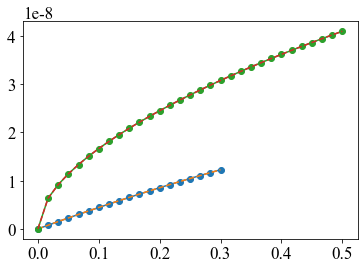

In [20]:
# check SEI growth and porosity decrease here:
# X-average porosity vs LLI TO SEI in mol plus LiP
L_p   =Para_0["Positive electrode thickness [m]"]
L_n   =Para_0["Negative electrode thickness [m]"]
L_s   =Para_0["Separator thickness [m]"]
L_y   =Para_0["Electrode width [m]"]   
L_z   =Para_0["Electrode height [m]"]
PoreVolNeg = Sol_0["X-averaged negative electrode porosity"].entries*L_n*L_y*L_z;
PoreVolSep = Sol_0["X-averaged separator porosity"].entries*L_s*L_y*L_z;
PoreVolPos = Sol_0["X-averaged positive electrode porosity"].entries*L_p*L_y*L_z;

LLINegSEI = (
    Sol_0["Loss of lithium to negative electrode SEI [mol]"].entries
    - 
    Sol_0["Loss of lithium to negative electrode SEI [mol]"].entries[0]
    )
LLINegSEIcr = (
    Sol_0["Loss of lithium to negative electrode sei-cracks [mol]"].entries
    - 
    Sol_0["Loss of lithium to negative electrode sei-cracks [mol]"].entries[0]
    )
LLINegLiP = (
    Sol_0["Loss of lithium to negative electrode lithium plating [mol]"].entries
    - 
    Sol_0["Loss of lithium to negative electrode lithium plating [mol]"].entries[0]
)
VmolSEI   = Para_0["Outer SEI partial molar volume [m3.mol-1]"] # 9.8e-5,
VmolLiP   = Para_0["Lithium metal partial molar volume [m3.mol-1]"] # 1.3e-05
Vol_SEILiP_increase = 1.0*(  (LLINegSEI+LLINegSEIcr)* VmolSEI + LLINegLiP * VmolLiP) 

PoreVolNeg_dec = PoreVolNeg[0] - PoreVolNeg;
# 
PoreVolNeg_1 = Sol_1["X-averaged negative electrode porosity"].entries*L_n*L_y*L_z;
PoreVolSep_1 = Sol_1["X-averaged separator porosity"].entries*L_s*L_y*L_z;
PoreVolPos_1 = Sol_1["X-averaged positive electrode porosity"].entries*L_p*L_y*L_z;

LLINegSEI_1 = (
    Sol_1["Loss of lithium to negative electrode SEI [mol]"].entries
    - 
    Sol_1["Loss of lithium to negative electrode SEI [mol]"].entries[0]
    )
LLINegSEIcr_1 = (
    Sol_1["Loss of lithium to negative electrode sei-cracks [mol]"].entries
    - 
    Sol_1["Loss of lithium to negative electrode sei-cracks [mol]"].entries[0]
    )
LLINegLiP_1 = (
    Sol_1["Loss of lithium to negative electrode lithium plating [mol]"].entries
    - 
    Sol_1["Loss of lithium to negative electrode lithium plating [mol]"].entries[0]
)
VmolSEI   = Para_0["Outer SEI partial molar volume [m3.mol-1]"] # 9.8e-5,
VmolLiP   = Para_0["Lithium metal partial molar volume [m3.mol-1]"] # 1.3e-05
Vol_SEILiP_increase_1 = 1.0*(  (LLINegSEI_1+LLINegSEIcr_1) * VmolSEI + LLINegLiP_1 * VmolLiP) 

PoreVolNeg_dec_1 = PoreVolNeg_1[0] - PoreVolNeg_1;

Time_1 =Sol_1["Time [h]"].entries

plt.plot(Time_1,Vol_SEILiP_increase_1,'-o')
plt.plot(Time_1,PoreVolNeg_dec_1,'--')

Time =Sol_0["Time [h]"].entries

plt.plot(Time,Vol_SEILiP_increase,'-o')
plt.plot(Time,PoreVolNeg_dec,'--')

In [30]:
Para_0.search("Outer SEI solvent diffusivity [m2.s-1]") 

Outer SEI solvent diffusivity [m2.s-1]	1.7e-20


In [ ]:
control parameter for different degradation mechanisms: 
for sei on cracks:
    Negative electrode cracking rate # function or 3.9e-20
    Positive electrode cracking rate # function or 3.9e-20
for LAM due to cracks:
    Negative electrode LAM constant propotional term # default 1e-3
    Positive electrode LAM constant propotional term # default 1e-3
for solvent-diffusion limited sei:
    Outer SEI solvent diffusivity [m2.s-1]
    Bulk solvent concentration [mol.m-3]
for ec reaction limited sei:
    EC diffusivity [m2.s-1]	# default 2e-18
    EC initial concentration in electrolyte [mol.m-3] # default 4541, set as default
    SEI kinetic rate constant [m.s-1] # default 1e-12
for interstitial-diffusion limited:
    Inner SEI lithium interstitial diffusivity [m2.s-1] # default 1e-12 
    Lithium interstitial reference concentration [mol.m-3] # default 15 (doesn't matter)



In [19]:
label = ["Sol_0","Sol_1"] 
output_variables3 = [
    "X-averaged total negative electrode sei-cracks thickness [m]",
    "Total negative electrode sei-cracks thickness [m]",
    ]
quick_plot = pb.QuickPlot([Sol_0,Sol_1], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=1800.0, step=18.0), Output()), _dom_classes=…

In [18]:
label = ["Sol_0","Sol_1"] 
output_variables3 = [
    "Loss of capacity to negative electrode SEI [A.h]",
    "Loss of capacity to negative electrode dead lithium plating [A.h]",
    "Loss of capacity to negative electrode lithium plating [A.h]",
    "Loss of capacity to negative electrode sei-cracks [A.h]",
    ]
quick_plot = pb.QuickPlot([Sol_0,Sol_1], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=1800.0, step=18.0), Output()), _dom_classes=…

In [14]:
label = ["Sol_0","Sol_1"] 
output_variables3 = [
                "Discharge capacity [A.h]", 
                "Negative electrode SOC",
                "Positive electrode SOC",
                "Electrolyte potential [V]",
                "Negative particle surface concentration [mol.m-3]",
                "Terminal voltage [V]",
                "SEI interfacial current density [A.m-2]",
                "Porosity"
            ]
quick_plot = pb.QuickPlot([Sol_0,Sol_1], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=1800.0, step=18.0), Output()), _dom_classes=…

In [ ]:
label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
output_variables3 = [
                "Discharge capacity [A.h]", 
                "Negative electrode SOC",
                "Positive electrode SOC",
                "Electrolyte potential [V]",
                "Negative particle surface concentration [mol.m-3]",
                "Terminal voltage [V]",
                "SEI interfacial current density [A.m-2]",
                "Porosity"
            ]
quick_plot = pb.QuickPlot([Sol_0,Sol_1], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
label = ["Diff_Li_SEI = 1e-16"] 
output_variables3 = [
                "Loss of capacity to negative electrode lithium plating [A.h]", 
                "Loss of capacity to negative electrode SEI [A.h]",
                "Negative electrode interfacial current density [A.m-2]",
            ]
quick_plot = pb.QuickPlot([Sol_0,], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:

Cap  =Sol_0["Discharge capacity [A.h]"].entries

Time =Sol_0["Time [h]"].entries
NegSoc=Sol_0["Negative electrode SOC"].entries
PosSoc=Sol_0["Positive electrode SOC"].entries


Num_subplot = 2; fs=19
fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
axs[0].plot(Time,Cap, '-', label="Cap" ) # first cycle
axs[1].plot(Time,NegSoc, '-',label="Neg" ) # last cycle
axs[1].plot(Time,PosSoc, '-',label="Pos" ) # last cycle
axs[0].set_ylabel("Discharge cap [A.h]",   fontdict={'family':'Times New Roman','size':fs})
axs[1].set_ylabel("SOC",   fontdict={'family':'Times New Roman','size':fs})
for i in range(0,Num_subplot):    
    axs[i].set_xlabel("Time [h]",   fontdict={'family':'Times New Roman','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)  

axs[0].set_title(f"Discharge capacity", fontdict={'family':'Times New Roman','size':fs+1})
axs[1].set_title(f"Electrode SOC", fontdict={'family':'Times New Roman','size':fs+1})

In [ ]:

plt.plot(Time,NegSoc)
plt.plot(Time,PosSoc)

In [ ]:
Experiment_Long_1   = pb.Experiment(  
    [(
        f"Discharge at 1 C until {V_min} V", 
        f"Charge at 0.3 C until {V_max} V", 
        f"Hold at {V_max} V until C/100"),  ] * 6  )  
Model_1= Model_0.set_initial_conditions_from(Sol_0, inplace=False)
Sim_1    = pb.Simulation(
    Model_1,        experiment = Experiment_Long_1,
    parameter_values = Para_0,
    solver = pb.CasadiSolver(),
    var_pts=var_pts,
    ) #mode="safe"
Sol_1    = Sim_1.solve()

In [ ]:
V_max = 4.2;        V_min = 2.5;   Temper_RPT = 25; 

#index 
ModelTimer = pb.Timer()
Total_Cycles = 16; save_at_cycles = 1;  

# Key scan parameters:
Ratio_excess_i = 1.04;
cs_Neg_Init_i = 28866 ; Diff_SEI_i = 1.7e-20; # Ruihe old: 28920  
R_SEI_i = 2E5;   Bulk_Sol_Con_i = 4541.0;
D_Li_inSEI_i = 3e-21;    # default: 1e-20 
c_Li_inte_ref_i = 15;    # default: 15
Couple_SEI_LiP_i = 1e-6; # default: 1e-6
k_LiP_i = 1E-10;         # default: 1e-10
Temper = 25;

Experiment_Long   = pb.Experiment(  
    [(
        f"Discharge at 1 C until {V_min} V", 
        f"Charge at 0.3 C until {V_max} V", 
        f"Hold at {V_max} V until C/100"),  ] * Total_Cycles  )  
        
for i in range(0,1):    ######################   update parameter and run first RPT
    ChemistryChen=pb.parameter_sets.Chen2020_coupled   
    ChemistryChen["electrolyte"] = "lipf6_Valoen2005"
    Para_0=pb.ParameterValues(chemistry=ChemistryChen)
    Para_0.update({"Negative electrode diffusivity [m2.s-1]": graphite_LGM50_diffusivity_ORegan2021_adjust})
    Para_0.update({"Positive electrode diffusivity [m2.s-1]": nmc_LGM50_diffusivity_ORegan2021_adjust})
    Para_0.update({"Negative electrode exchange-current density [A.m-2]": 
        graphite_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust})
    Para_0.update({"Positive electrode exchange-current density [A.m-2]": 
        nmc_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust})
    Para_0.update({"Positive electrode conductivity [S.m-1]": 
        0.8473})
    Para_0.update({"Negative electrode Bruggeman coefficient (electrode)": 
        0.0})
    #Para_0.update({'Initial concentration in negative electrode [mol.m-3]':cs_Neg_Init_i })
    #Para_0.update({'Initial concentration in positive electrode [mol.m-3]':13975 })  
    Para_0.update({'SEI resistivity [Ohm.m]':R_SEI_i}) ;
    Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI_i});
    Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con_i});
    Para_0.update({'Initial electrolyte excessive amount ratio':Ratio_excess_i})   # 
    Para_0.update({'Inner SEI lithium interstitial diffusivity [m2.s-1]':D_Li_inSEI_i})       
    Para_0.update({'Lithium interstitial reference concentration [mol.m-3]':c_Li_inte_ref_i}) 
    Para_0.update({"SEI-plating coupling constant [s-1]": Couple_SEI_LiP_i})     
    Para_0.update({'Lithium plating kinetic rate constant [m.s-1]':k_LiP_i})                
    Para_0.update({'Current solvent concentration in the reservoir [mol.m-3]':Bulk_Sol_Con_i})     
    Para_0.update({'Current electrolyte concentration in the reservoir [mol.m-3]':1000.0})           
    Para_0.update({'Ratio of Li-ion concentration change in electrolyte consider solvent consumption':  
                    1.0 })
    Model_11 = pb.lithium_ion.DFN(     
    options={
        "particle": "Fickian diffusion",          
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",         
        "lithium plating":"partially reversible"     } ) #
    ModelTimer = pb.Timer()
    mesh_neg = 50; mesh_pos = 50; 
    var = pb.standard_spatial_vars  
    var_pts = {var.x_n: 20,  var.x_s: 10,  var.x_p: 20,  var.r_n: mesh_neg,  var.r_p: mesh_pos,  }
    Sim_11    = pb.Simulation(
        Model_11,        experiment = Experiment_Long,
        parameter_values = Para_0,
        solver = pb.CasadiSolver(),
        var_pts=var_pts,
        ) #mode="safe"
    Sol_11    = Sim_11.solve()

In [ ]:
Experiment_Long_6   = pb.Experiment(  
    [(
        f"Discharge at 1 C for 3928 s", ), ] * 1  ) 
Model_6= Model_0.set_initial_conditions_from(Sol_0, inplace=False)
Sim_6 = pb.Simulation(
        Model_6,
        experiment = Experiment_Long_6, 
        parameter_values=Para_0, 
        solver = pb.CasadiSolver(),
        #var_pts=var_pts,
    )
Sol_6 = Sim_6.solve() 

In [ ]:
Para_0.update({"Negative electrode Bruggeman coefficient (electrode)": 
        0.0})
def nmc_LGM50_diffusivity_ORegan2021_adjust_2(sto, T):
    a1 = -0.9231
    a2 = -0.4066
    a3 = -0.993
    b1 = 0.3216
    b2 = 0.4532
    b3 = 0.8098
    c0 = -13.96
    c1 = 0.002534
    c2 = 0.003926
    c3 = 0.09924
    d = 1449

    D_ref = (
        10
        ** (
            c0
            + a1 * exp(-((sto - b1) ** 2) / c1)
            + a2 * exp(-((sto - b2) ** 2) / c2)
            + a3 * exp(-((sto - b3) ** 2) / c3)
        )
        * 10  # correcting factor (see O'Regan et al 2021)
    )

    E_D_s = d * constants.R
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius
    
Para_0.update({"Positive electrode diffusivity [m2.s-1]": 
        nmc_LGM50_diffusivity_ORegan2021_adjust_2})

Experiment_Long_7   = pb.Experiment(  
    [(
        f"Discharge at 1 C for 3929 s", ), ] * 1  ) 
Model_7= Model_0.set_initial_conditions_from(Sol_0, inplace=False)
Sim_7 = pb.Simulation(
        Model_7,
        experiment = Experiment_Long_7, 
        parameter_values=Para_0, 
        solver = pb.CasadiSolver(),
        #var_pts=var_pts,
    )
Sol_7 = Sim_7.solve() 

In [ ]:
# Now we have: Sol_6 (dis 3928) Sol_5 (dis 3900) Sol_4 (dis 3928) Sol_0 (normal 5 cycles)